In [242]:
###
# Group Members
# Clarise Poobalan : 383321
# Nicolaas Cawood: 2376182
# Shikash Algu: 2373769
# Byron Gomes: 0709942R
###


from collections import defaultdict
from collections import namedtuple
import sys
import itertools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gym

EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


# Helper functions
##################
def blackjack_plot_value_function(V, title="Value Function", suptitle="MC Blackjack-v0"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(
        lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(
        lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))
    fig = plt.figure(figsize=(20, 15))
    st = fig.suptitle(suptitle, fontsize="large")

    def plot_surface(X, Y, Z, title, plot_positon=111):
        ax = fig.add_subplot(plot_positon, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title), 211)
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title), 212)
    fig.tight_layout()

    # shift subplots down:
    st.set_y(0.99)
    fig.subplots_adjust(top=0.93)

    fig.savefig(title + "_blackjack_plot_value_function.png")
    plt.show()


def td_plot_episode_stats(stats, algor_name="", smoothing_window=10):
    # Plot the episode length over time

    fig = plt.figure(figsize=(10, 10))
    st = fig.suptitle(algor_name, fontsize="large")

    # fig1 = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(311)
    ax1.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    ax1.set_title("Episode Length over Time")

    # Plot the episode reward over time
    # fig2 = plt.figure(figsize=(10, 5))
    ax2 = fig.add_subplot(312)
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(
        smoothing_window, min_periods=smoothing_window).mean()
    ax2.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    ax2.set_title("Episode Reward over Time (Smoothed over window size {})".format(
        smoothing_window))

    # Plot time steps and episode number
    # fig3 = plt.figure(figsize=(10, 5))
    ax3 = fig.add_subplot(313)
    ax3.plot(np.cumsum(stats.episode_lengths),
             np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    ax3.set_title("Episode per time step")

    fig.tight_layout()

    # shift subplots down:
    st.set_y(0.99)
    fig.subplots_adjust(top=0.93)

    fig.savefig(algor_name + "_td_plot_episode_stats.png")
    plt.show(block=False)


def td_plot_values(Q, algor_name="", state_shape=((4, 12))):
    """ helper method to plot a heat map of the states """

    values = np.zeros((4 * 12))
    max_a = [0 for _ in range(values.shape[0])]
    for key, value in Q.items():
        values[key] = max(value)
        max_a[key] = int(argmax(value))

    def optimal_move(i, j):
        left, right, down, up = (
            i, max(j - 1, 0)), (i, min(11, j + 1)), (min(3, i + 1), j), (max(0, i - 1), j)
        arr = np.array([values[up], values[right], values[down], values[left]])
        if i == 2 and j != 11:
            arr[2] = -9999
        if i == 0:
            arr[0] = -999
        if j == 0:
            arr[3] = -999
        if j == 11:
            arr[1] = -999
        return argmax(arr)

    # reshape the state-value function
    values = np.reshape(values, state_shape)
    # plot the state-value function
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    im = ax.imshow(values, cmap=matplotlib.cm.coolwarm)
    arrows = ['↑', '→', '↓', '←']
    index = 0
    for (j, i), label in np.ndenumerate(values):
        ax.text(i, j, np.round(label, 3),
                ha='center', va='center', fontsize=12)
        if j != 3 or i == 0:
            ax.text(i, j + 0.4, arrows[optimal_move(j, i)],
                    ha='center', va='center', fontsize=12, color='black')
        index += 1
    plt.tick_params(bottom=False, left=False,
                    labelbottom=False, labelleft=False)
    plt.title(algor_name + ': State-Value Function')
    fig.savefig(algor_name + "_td_plot_values.png")
    plt.show(block=False)


##################

In [243]:
def blackjack_sample_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    if observation[0] >= 20:
        action = 0 #sticks
    else:
        action = 1 #hits
    
    return action
    #raise NotImplementedError

In [244]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0, max_steps_per_episode=9999, print_=False):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.

    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        print_: print every num of episodes - don't print anything if False

    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """
    # Keeps track of sum and count of returns for each state to calculate an average.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    
    for i_episode in range(num_episodes):
        current_observation = env.reset() #initial step
        episodes = []
        for i in range(max_steps_per_episode):
            action = policy(current_observation)
            next_observation, reward, done, _ = env.step(action)
            episodes.append((current_observation, action, reward))
            if done:
                break
            current_observation = next_observation
           
        observations = set([x[0] for x in episodes])#gets all the player observations (player sum, dealer points, ace presence) after every hit and puts them in one list
        #print("observations: {}".format(observations))
        G = 0
        for i, observation in enumerate(observations): #for every element in observations
            idx = episodes.index([episode for episode in episodes if episode[0] == observation][0]) #getting the index of the observation in th episode list

            #G = R(t+1)+gamma*G
            G = sum([episode[2] * discount_factor ** i for episode in episodes[idx:]]) #episode[2] is the reward of that step in the episode
            
            returns_sum[observation] += G
            returns_count[observation] += 1.0
            
            V[observation] = returns_sum[observation] / returns_count[observation]
                
    return V

In [245]:
def run_mc():
    # Exploring the BlackjackEnv
    # create env from https://gym.openai.com/envs/Blackjack-v0/
    blackjack_env = gym.make('Blackjack-v0')
    # let's see what's hidden inside this Object
    print(vars(blackjack_env))

    # how big is the action space ?2,  The action are  hit=1, stick=0
    print('number of actions:', blackjack_env.action_space.n)
    # let see the observation space - The observation of a 3-tuple of: the players current sum,
    #     the dealer's one showing card (1-10 where 1 is ace),
    #     and whether or not the player holds a usable ace (0 or 1).
    print('observation_space', blackjack_env.observation_space)
    observation = blackjack_env.reset()
    print('observation:', observation)
    # let's sample a random action
    random_action = blackjack_env.action_space.sample()
    print('random action:', random_action)
    # let's simulate one action
    next_observation, reward, done, _ = blackjack_env.step(random_action)
    print('next_observation:', next_observation)
    print('reward:', reward)
    print('done:', done)

    print("\nmc_prediction 10,000_steps\n")
    values_10k = mc_prediction(
        blackjack_sample_policy, blackjack_env, num_episodes=10000, print_=True)
    blackjack_plot_value_function(values_10k, title="10,000 Steps")

    print("\nmc_prediction 500,000_steps\n")
    values_500k = mc_prediction(
        blackjack_sample_policy, blackjack_env, num_episodes=500000, print_=True)
    blackjack_plot_value_function(values_500k, title="500,000 Steps")

    print("\nmc_control_epsilon_greedy\n")
    Q, policy = mc_control_epsilon_greedy(
        blackjack_env, num_episodes=500000, epsilon=0.1, print_=True)
    # For plotting: Create value function from action-value function by picking the best action at each state
    values = defaultdict(float)
    for state, actions in Q.items():
        action_value = np.max(actions)
        values[state] = action_value
    blackjack_plot_value_function(values, title="Optimal Value Function")

In [246]:
def argmax(numpy_array):
    """ argmax implementation that chooses randomly between ties """
    return np.random.choice(np.flatnonzero(numpy_array == numpy_array.max()))

In [247]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.

    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(observation):
        props = np.ones(nA, dtype = float) * epsilon / nA
        best_action = argmax(Q[observation])
        props[best_action] += 1. - epsilon
        return props

    return policy_fn

In [252]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1, max_steps_per_episode=100,
                              print_=False):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.

    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        print_: print every num of episodes - don't print anything if False
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state to calculate an average.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    #E-greedy policy
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    #Repeat for each episode
    for i_episode in range(num_episodes):
        current_observation = env.reset()
        #print("Episode no: {}".format(i_episode))
        #Generate an epsiode
        episodes = []
        for i in range(max_steps_per_episode):
            probs = policy(current_observation)
            action = np.random.choice(np.arange(len(probs)), p = probs)
            next_observation, reward, done, _ = env.step(action)
            episodes.append((current_observation, action, reward))
            
            if done:
                break
            current_observation = next_observation
        #print("Episode no: {}, episode {}".format(i_episode, episodes))
        # find the unique observation
        pairs = set([(episode[0], episode[1]) for episode in episodes])
        for (observation, action) in pairs:
            pair = (observation, action)
            # find the first occurence of the observation
            idx = episodes.index([episode for episode in episodes if episode[0] == observation and episode[1] == action][0])
            V = sum([reward[2] * discount_factor ** i for i, reward in enumerate(episodes[idx:])])
            
            returns_sum[pair] += V
            returns_count[pair] += 1.
            
            Q[observation][action] = returns_sum[pair] / returns_count[pair]
    
    return Q, policy    

{'action_space': Discrete(2), 'observation_space': Tuple(Discrete(32), Discrete(11), Discrete(2)), 'np_random': RandomState(MT19937) at 0x24895895598, 'natural': False, 'dealer': [9, 10], 'player': [6, 4], 'spec': EnvSpec(Blackjack-v0)}
number of actions: 2
observation_space Tuple(Discrete(32), Discrete(11), Discrete(2))
observation: (20, 2, False)
random action: 1
next_observation: (24, 2, False)
reward: -1.0
done: True

mc_prediction 10,000_steps



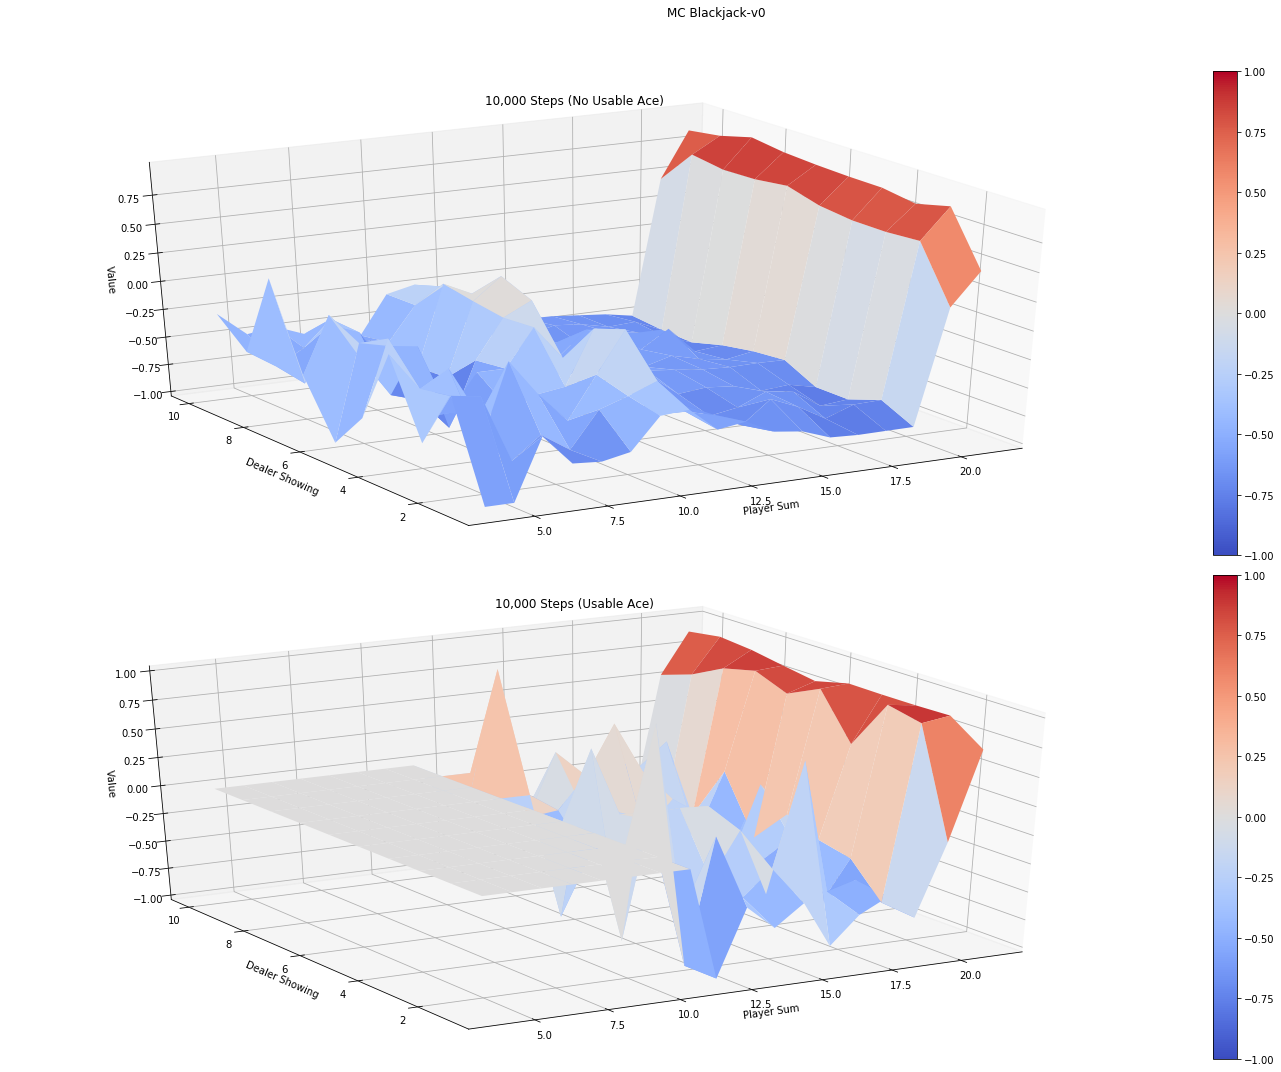


mc_prediction 500,000_steps



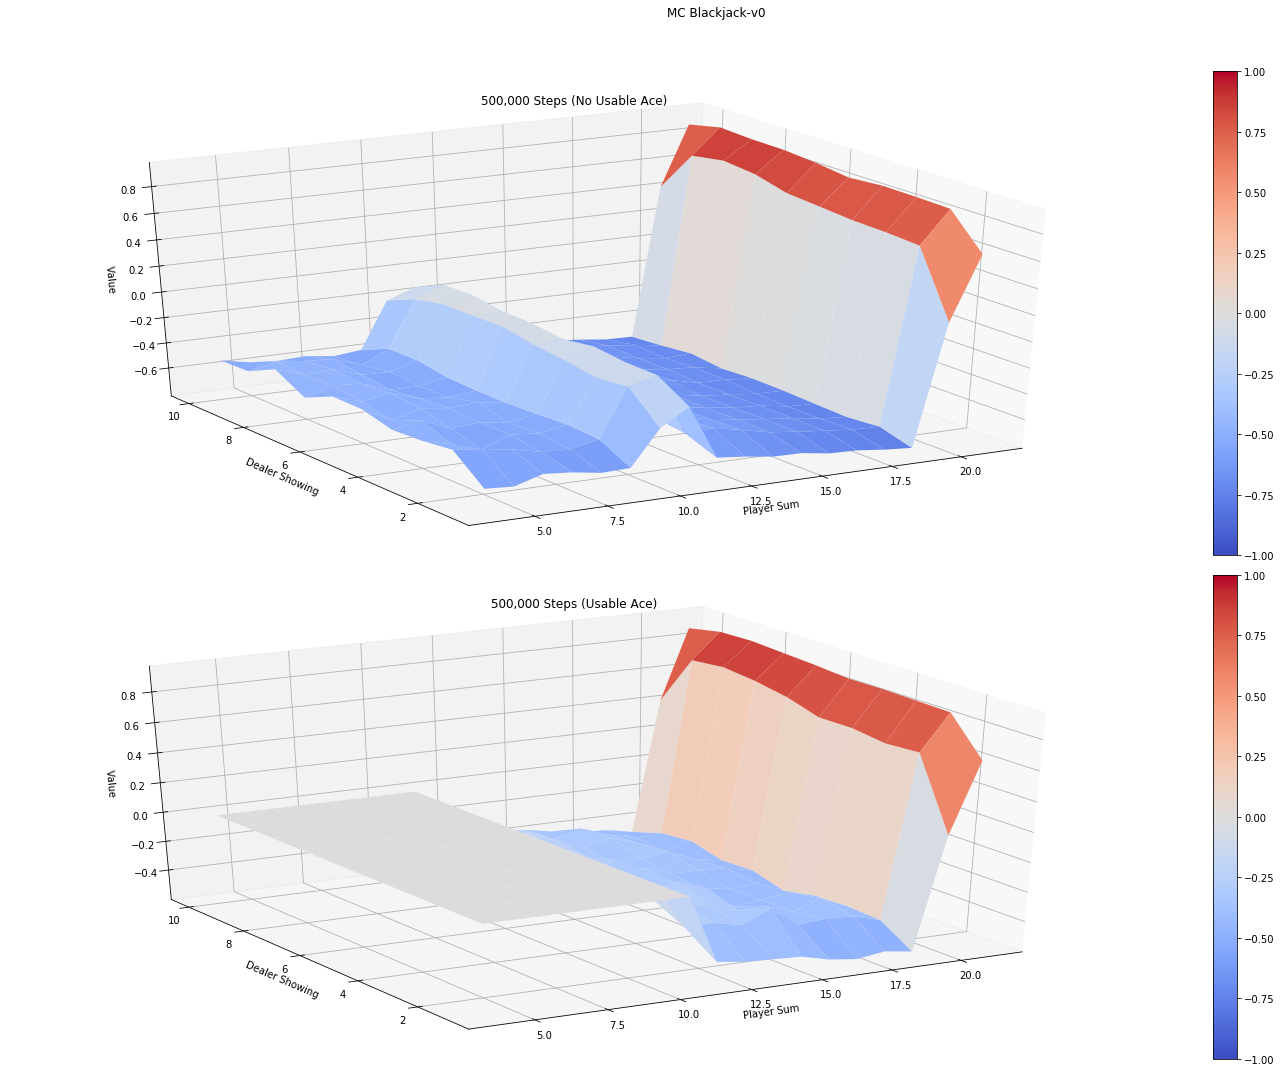


mc_control_epsilon_greedy



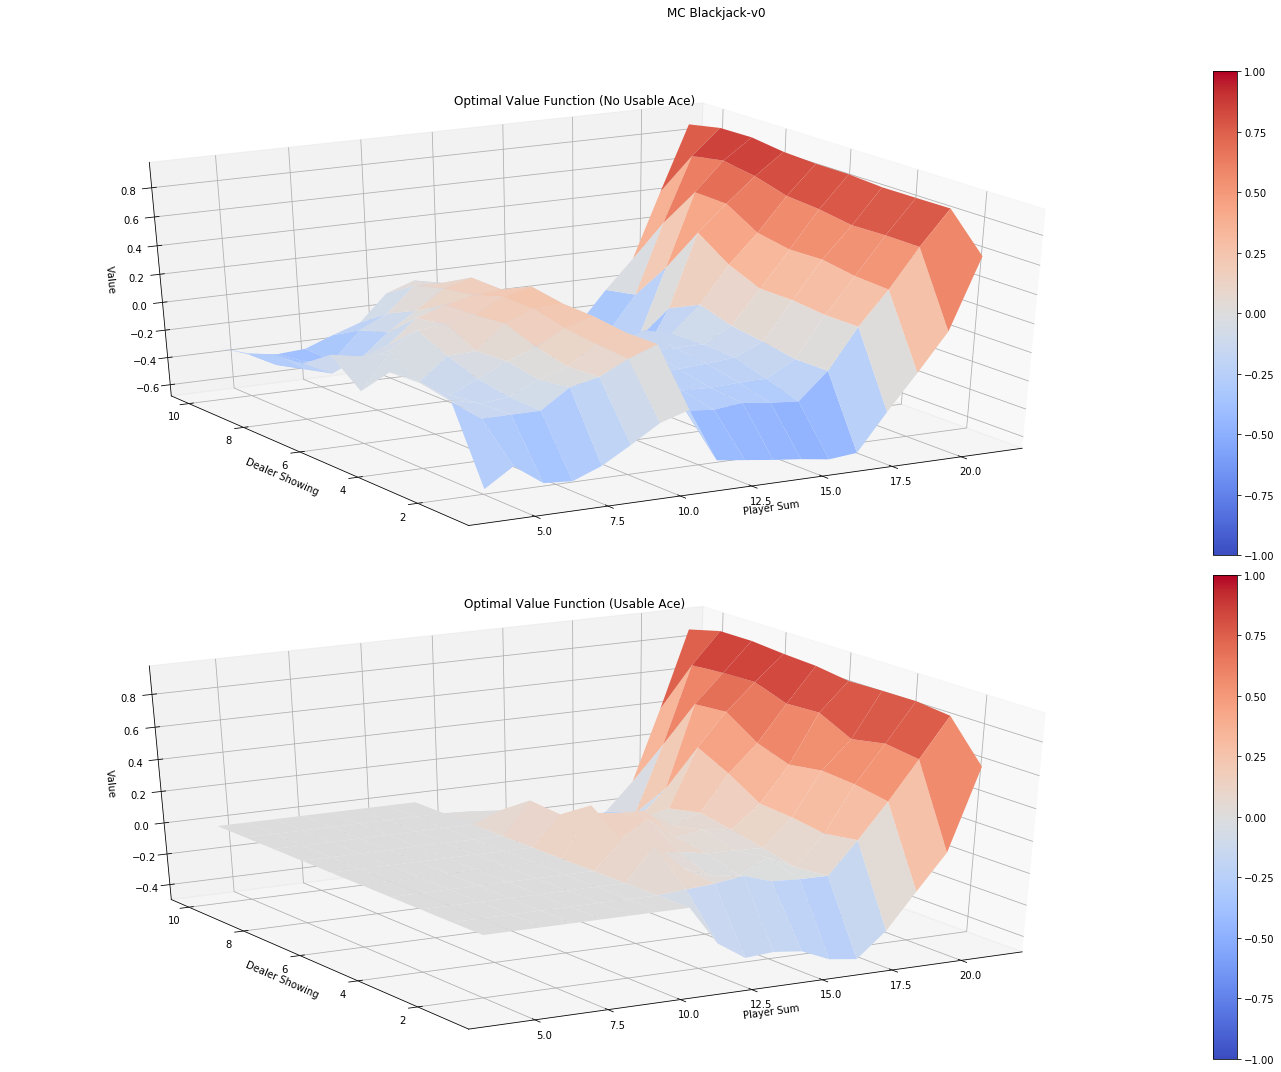

In [253]:
run_mc()

Question 4.

Answer:

In [340]:
def q_learning(env, num_episodes, discount_factor=1.0, epsilon=0.05, alpha=0.5, print_=False):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        print_: print every num of episodes - don't print anything if False

    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #Q lists every action (4) each state
 
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    #Repeat for each episode
    for i_episode in range(num_episodes):
        current_observation = env.reset()
        t = 0
        reward = 0
        while True:
            t+= 1
            probs = policy(current_observation)
            action = np.random.choice(np.arange(len(probs)), p = probs)
            next_observation, reward, done, _ = env.step(action)
            #episodes.append((current_observation, action, reward))
            
        #for each step in the episode
        #for i_step in range(len(episodes))
            #Q-table update rule
            
            Q[current_observation][action] = Q[current_observation][action] + alpha*(float(reward)+discount_factor*max(Q[next_observation])-Q[current_observation][action])
            current_observation = next_observation
            
        # Update statistics after getting a reward - use within loop, call the following lines
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            if done:
                break
    return Q, stats


In [355]:
def SARSA(env, num_episodes, discount_factor=1.0, epsilon=0.1, alpha=0.5, print_=False):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        print_: print every num of episodes - don't print anything if False

    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #Q lists every action (4) each state
 
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    #Repeat for each episode
    for i_episode in range(num_episodes):
        current_observation = env.reset()
        probs = policy(current_observation)
        action = np.random.choice(np.arange(len(probs)), p = probs)
        t = 0
        reward = 0
        while True:
            t+= 1
            next_observation, reward, done, _ = env.step(action)
            next_probs = policy(next_observation)
            next_action = np.random.choice(np.arange(len(next_probs)), p = next_probs)

            #Q-table update rule
            Q[current_observation][action] = Q[current_observation][action] + alpha*(reward+discount_factor*Q[next_observation][next_action]-Q[current_observation][action])
            current_observation = next_observation
            action = next_action
            
        # Update statistics after getting a reward - use within loop, call the following lines
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            if done:
                break
    return Q, stats

In [360]:
def run_td():
    num_episodes = 1000
    discount_factor = 1.0
    epsilon = 0.1
    alpha = 0.5

    # create env : https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py
    cliffwalking_env = gym.make('CliffWalking-v0')
    cliffwalking_env.render()
    #print("Action Space: {}".format(cliffwalking_env.action_space.n))
    #print("State Space: {}".format(cliffwalking_env.observation_space.n))
    #state = cliffwalking_env.reset()
    #action = cliffwalking_env.action_space.sample()
    #print("Current State: {}".format(state))
    #print("Action to take: {}".format(action))
    #next_state, reward, done, info = cliffwalking_env.step(action)
    #print("Next State: {}".format(next_state))
    #print("Reward: {}".format(reward))
    #print("Done: {}".format(done))
    #print("Info: {}".format(info))
    #state = next_state
    #print("")
   

    print('SARSA\n')
    sarsa_q_values, stats_sarsa = SARSA(cliffwalking_env, num_episodes=num_episodes,
                                        discount_factor=discount_factor, epsilon=epsilon,
                                        alpha=alpha, print_=True)
    td_plot_episode_stats(stats_sarsa, "SARSA")
    td_plot_values(sarsa_q_values, "SARSA")
    print('')

    print('Q learning\n')
    ql_q_values, stats_q_learning = q_learning(cliffwalking_env, num_episodes=num_episodes,
                                               discount_factor=discount_factor,
                                               epsilon=epsilon,
                                               alpha=alpha, print_=True)
    td_plot_episode_stats(stats_q_learning, "Q learning")
    td_plot_values(ql_q_values, "Q learning")
    print('')

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

SARSA



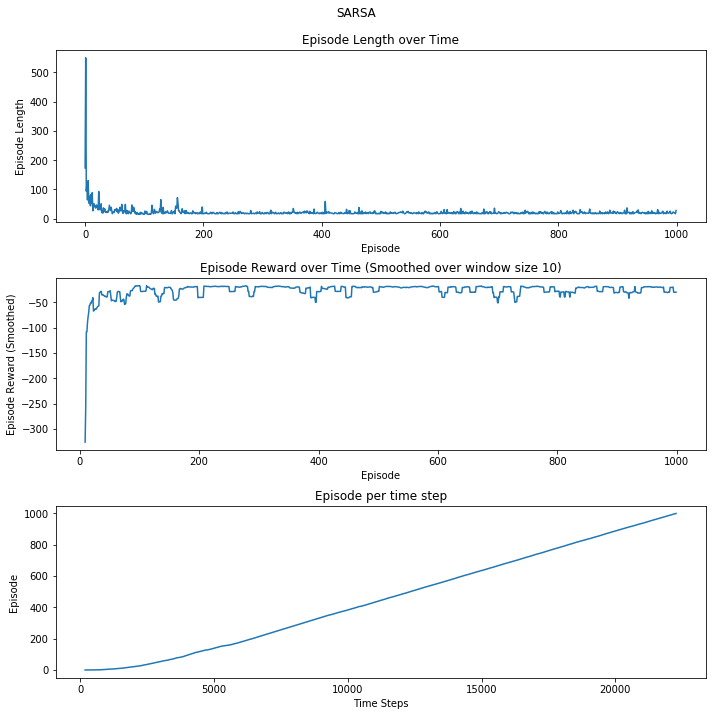

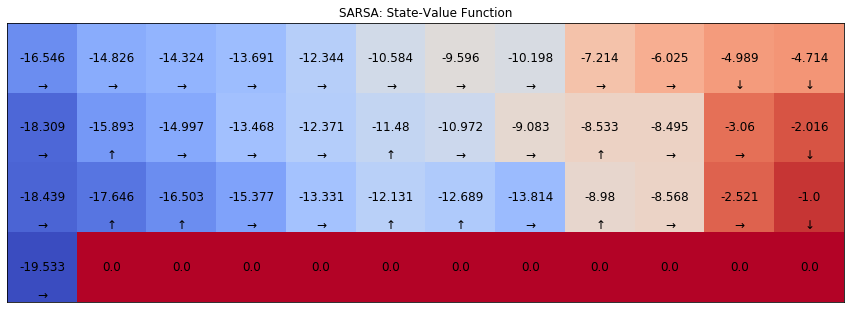


Q learning



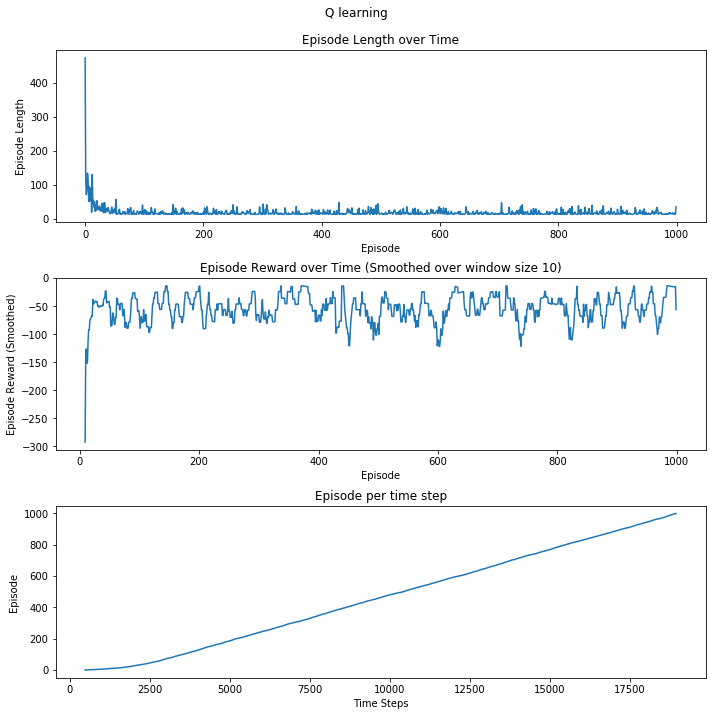

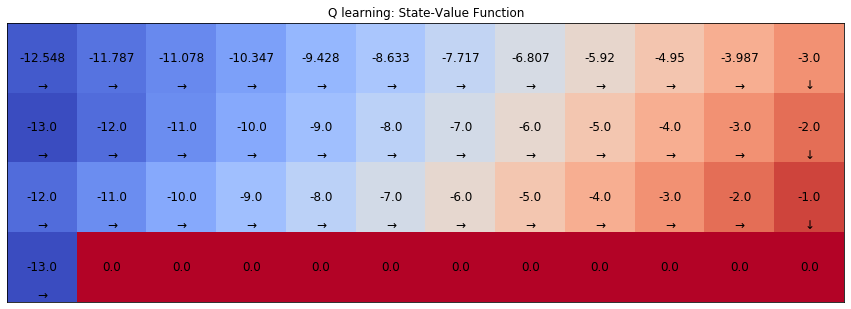

In [361]:
run_td()